# Different data formats

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib

import numpy as np
import pandas as pd
from rich import print

import cellpy
from cellpy.utils import example_data, plotutils

In [3]:
# Comment out this when running the notebook locally to get interactive plots
import plotly.io as pio
pio.renderers.default = "png"

In [4]:
def head(f, n=5):
    print(f" {f.name} ".center(80, "-"))
    with open(f) as datafile:
        for j in range(n):
            line = datafile.readline()
            print(f"[{j+1:02}] {line.strip()}")
        

## PEC CSV data

In [5]:
p = example_data.pec_file_path()
print(f"{p.name=}")

p.name='pec.csv'

In [6]:
head(p, 35)

----------------------------------- pec.csv ------------------------------------

[01] Request Year:,2019

[02] Test:,187

[03] Test Description:,

[04] TestRegime Name:,FirstCell dQdV C/25

[05] TestRegime Suffix:,HWL

[06] TestRegime CellSize:,Default cellsize

[07] TestRegime Version:,1

[08] Project Group Name:,Immediate

[09] Project Group Description:,Immediate

[10] Project Group Memo:,

[11] Project Group Storage Environment:,R.T./AMB

[12] Project Group Test Environment:,R.T./AMB

[13] Number Of Cells:,1

[14] Parameter names:,

[15] Parameter values:,

[16] Variable names:

[17] LotID:,

[18] Lot Description:,

[19] Date Made:,1/21/2003 0:00

[20] Origin:,Other

[21] Requestor:,Admin

[22] Product ID:,Default product

[23] Storage Temp:,R.T./AMB

[24] Storage Delay:,0 days

[25] Test Temp:,R.T./AMB

[26] Start Time:,02/22/2019 16:21:35

[27] End Time:,1/1/0001 0:00

[28] Operator Instructions:,Also connect cell temp to channel TC-K and ambient temp to NTC

[29] #RESULTS CHECK

[30] ReqYear,Test,CellNr,Type,Value,Reason,

[31] 2019,187,1,1,3272,3,

[32] #END RESULTS CHECK

[33] Test,Cell,Rack,Shelf,Position,Cell ID,Step,Cycle,Total Time (Seconds),Load On Time (Seconds),Step Time 
(Seconds),Cycle Charge Time (Seconds),Cycle Discharge Time (Seconds),Real Time,Position Start Time,Voltage 
(mV),Current (mA),Charge Capacity (mAh),Discharge Capacity (mAh),Charge Capacity (mWh),Discharge Capacity 
(mWh),ReasonCode,50% DoD (mV),PeakPower 1 (W),PeakPower 2 (W),Open Circuit Voltage 1 (V),Open Circuit Voltage 2 
(V),Internal Resistance 1 (mOhm),Internal Resistance 2 (mOhm),Ambient temperature (Â°C),Cell surface temperature 
(Â°C),DC Internal Resistance (mOhm),AC Internal Resistance (mOhm),Station Temperature (Â°C),

[34] 187,1,SBT0550,001,1,,0,0,1,0,1,0,0,02/22/2019 16:23:27,02/22/2019 
16:23:26,3272.632,0,0,0,0,0,30,0,0,0,0,0,0,0,25.83,24.9,,,,

[35] 187,1,SBT0550,001,1,,0,0,5,0,5,0,0,02/22/2019 16:23:31,02/22/2019 
16:23:26,3272.2776,0,0,0,0,0,30,0,0,0,0,0,0,0,25.83,24.9,,,,

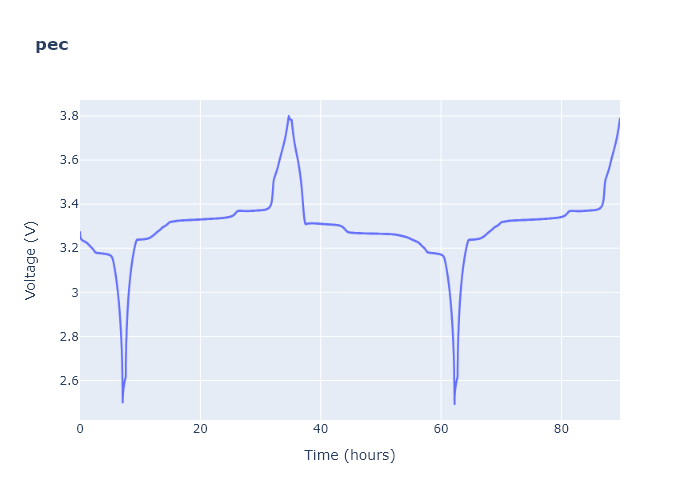

In [7]:
c = cellpy.get(p, instrument="pec_csv", cycle_mode="full_cell")
plotutils.raw_plot(c)

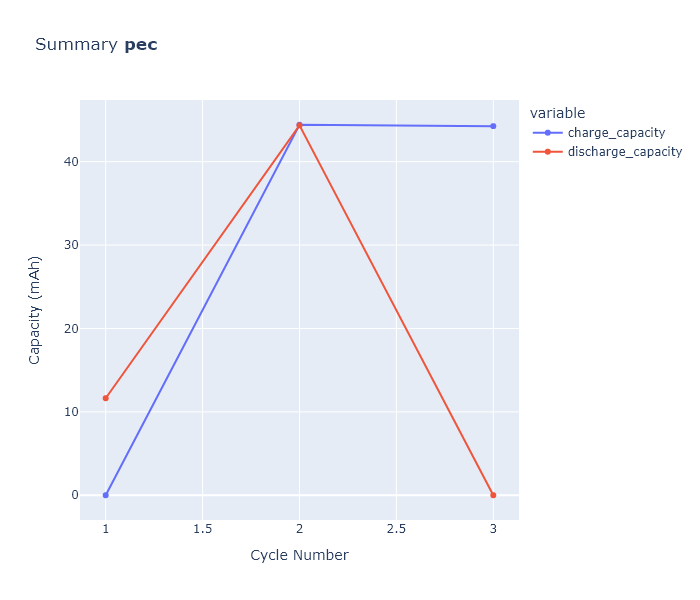

In [8]:
plotutils.summary_plot(c, y="capacities")

## MACCOR

In [9]:
data = pathlib.Path(r"C:\scripting\cellpy_dev_resources\dev_data\simba_Maccor\S4000")

In [10]:
from cellpy.readers import core

In [11]:
maccors = core.find_all_instruments("maccor")
print(maccors)

{'maccor_txt': ('maccor_txt', WindowsPath('C:/scripting/cellpy/cellpy/readers/instruments/maccor_txt.py'))}

In [12]:
maccor_instrument_factory = core.InstrumentFactory()
maccor_instrument_factory.register_builder("maccor_txt", maccors["maccor_txt"])
models = maccor_instrument_factory.query("maccor_txt", "supported_models")

In [13]:
maccor = maccor_instrument_factory.create("maccor_txt")

In [14]:
print(models.keys())

dict_keys(['ZERO', 'ONE', 'TWO', 'THREE', 'FOUR', 'S4000-UBHAM', 'S4000-KIT', 'S4000-WMG'])

In [ ]:
# TWO / S4000-KIT: KIT-Full-cell-PW-HC-CT-cell013.txt
# FOUR / S4000-WMG: WMG-SIM-A7-1039 - 073_new.txt
# ONE / S4000-UBHAM: 01_UBham_CD_M50_Validation_0deg_01.txt

### Checking all the files

In [20]:
print(result)

{
    '01_UBham_CD_M50_Validation_0deg_01.txt': ['ONE', 'S4000-UBHAM'],
    '01_WMG_CD_Example MACCOR_cycling number.TXT': [],
    '01_WMG_CD_Example MACCOR_voltage profiles.TXT': [],
    'KIT-CW-SIMBA-ET-FC-NAPF6-007.037-Full_data.txt': ['TWO', 'S4000-KIT'],
    'KIT-Full-cell-PW-HC-CT-cell002.txt': ['TWO', 'S4000-KIT'],
    'KIT-Full-cell-PW-HC-CT-cell009.txt': ['TWO', 'S4000-KIT'],
    'KIT-Full-cell-PW-HC-CT-cell013.txt': ['TWO', 'S4000-KIT'],
    'KIT-Full-cell-PW-HC-CT-cell015.txt': ['TWO', 'S4000-KIT'],
    'KIT-Full-cell-PW-HC-ET-cell007.txt': ['TWO', 'S4000-KIT'],
    'KIT-Full-cell-PW-HC-ET-cell016.txt': ['TWO', 'S4000-KIT'],
    'WMG-SIM-A7-1039 - 073.txt': ['FOUR', 'S4000-WMG'],
    'WMG-SIM-A7-1039 - 073_new.txt': ['FOUR', 'S4000-WMG'],
    'WMG-SIM-A7-1047-ET - 079.txt': ['FOUR', 'S4000-WMG'],
    'WMG-SIM-A7-1047-ET - 079_new.txt': ['FOUR', 'S4000-WMG'],
    'WMG-SIM-A7-1475-END - 093.txt': ['FOUR', 'S4000-WMG']
}

In [21]:
for key, value in result.items():
    if not len(value):
        print(f"NO-LOADER: {key}")

NO-LOADER: 01_WMG_CD_Example MACCOR_cycling number.TXT

NO-LOADER: 01_WMG_CD_Example MACCOR_voltage profiles.TXT

#### Does not throw exception, but must be checked
- `01_UBham_CD_M50_Validation_0deg_01.txt`

#### Not raw file
- `01_WMG_CD_Example MACCOR_cycling number.TXT`
- `01_WMG_CD_Example MACCOR_voltage profiles.TXT`

#### With cut last line (but works)
- `KIT-Full-cell-PW-HC-CT-cell013.txt`

#### Similar files works, but this fails
- `KIT-Full-cell-PW-HC-CT-cell015.txt`

#### Fails for unknown reason
- `WMG-SIM-A7-1039 - 073.txt`
- `WMG-SIM-A7-1039 - 073_new.txt`
- `WMG-SIM-A7-1047-ET - 079.txt`
- `WMG-SIM-A7-1047-ET - 079_new.txt`
- `WMG-SIM-A7-1475-END - 093.txt`

### PLAN

- [x] check why `KIT-Full-cell-PW-HC-CT-cell013.txt` works and not `KIT-Full-cell-PW-HC-CT-cell015.txt`
- [x] fix "Fails for unknow reason"
- [ ] check "Does not throw exception, but must be checked"

## NEWARE

## Custom data